In [ ]:
#Extraction des carateristiques
#Consiste a utiliser les representations apprises par un reseau precedent pour extraire des caracteristiques interessantes dans des nouveaux Exemples
#on reutilise la base de convolution et non le reseau entierement connectee car il sont generalement plus generiques
#Le niveau de generalisation des representations depend de lamprofondeur de la couche du modele
#models dispo dans Keras, tous entrainees sur ImageNet ( Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet)

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-02-07 22:12:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  28.8MB/s    in 2.3s    

2023-02-07 22:12:13 (28.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# on ajoutera le classifieur entierement connecte sur la carte finale de caracteristique de la forme (4,4,512)
#Extraction des carateristiques sans augmentation des donnees

import os
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

base_dir = '/tmp/cats_and_dogs_filtered/'

train_dir = '/tmp/cats_and_dogs_filtered/train'

validation_dir = '/tmp/cats_and_dogs_filtered/validation'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      #Comme les generateur produise des donnees indefiniment dans une boucle, on doit utiliser
      # break" apres que chaque image aura ete vue une fois
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

#les caracteristiques extraites sont de la forme (sample_count, 4, 4, 512), on les envoie au reseau entierement connecte, 
#mais avant on doit les applatir

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))



Found 2000 images belonging to 2 classes.
1/1 [==============================] - 5s 5s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step


In [ ]:
#Definition su reseau entierement connecte
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 3s 22ms/step - loss: 0.5896 - acc: 0.6830 - val_loss: 0.4329 - val_acc: 0.8420
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4162 - acc: 0.8145 - val_loss: 0.3706 - val_acc: 0.8460
Epoch 3/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3536 - acc: 0.8525 - val_loss: 0.3265 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 2s 18ms/step - loss: 0.3116 - acc: 0.8720 - val_loss: 0.3276 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2859 - acc: 0.8785 - val_loss: 0.2956 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2548 - acc: 0.8995 - val_loss: 0.2925 - val_acc: 0.8680
Epoch 7/30
100/100 [==============================] - 2s 18ms/step - loss: 0.2487 - acc: 0.9010 - val_loss: 0.2837 - val_acc: 0.8860
Epoch 8/30
100/100 [==============================] - 3s 26ms/step - 

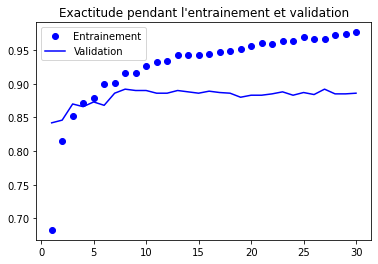

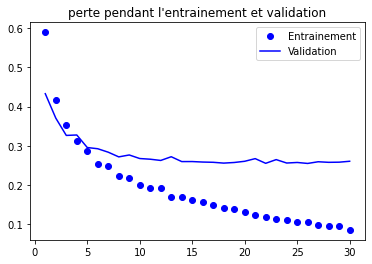

In [ ]:
#tracement des courbes de pertes et d'exactitude pendant la phase d'entrainement du ,model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Entrainement')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Exactitude pendant l\'entrainement et validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('perte pendant l\'entrainement et validation')
plt.legend()

plt.show()

In [ ]:
#reseau en sur ajustement malgre le Dropout , on doit utiliser la data augmentation
#technique trop couteuse car on l'utilise pendant l'entrainement des donnees

#figer une couche signifie empecher la mise a jour des poids pendant l'entrainement (conv_base.trainable = False)

#A part l'extraction des carateristiques, on peut utiliser le reglage de precision. il s'agit de liberer, dans le model figer,
# quelques couches superieur de la base de convolution qui est utiliser pour l'extraction des caracteristiques et a l'entrainer 
#conjointement avec la partie nouvellement ajoutee du modele(dans ce cas le classifieur)  et ses couches superieures liberees
#Etapes de reglage de precision 
#1) Ajouter le reseau personnalise au-dessus d'un reseau de base deja entrainnee
#2) Figer le reseau de base
#3) Entrainer la partie
#4) liberer certaines couche du reseau de base
#5) Entrainer conjointement ces couches liberees et le reseau ajoutee